In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_momentum_fit_res_both/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_weighted.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Cross section for single differnetial in Momentum (no sys)

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_momentum_fit.root","RECREATE");

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
#filename_overlay = 'NuCCana_overlay_V26_weight.root'
filename_overlay = 'NuCCana_overlay_V26_mar18.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	1012051
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.26811760704e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.0060278320856
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4_noflux.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	1013969
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')

energy_cut = ' && MCle_Energy>0.15'

numu_signal = numu_signal+energy_cut
numu_true = numu_true+energy_cut
numu_nomu = numu_nomu+energy_cut
numu_lowpur = numu_lowpur+energy_cut
numu_nc = numu_nc+energy_cut
numu_ov = numu_ov+energy_cut
numu_other = numu_other+energy_cut

num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [12]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [14]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [15]:
from array import array
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

In [16]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1' #\
                #&& MCle_Energy>0 && MCle_Energy<2.5 && TrackMomMCS_mom>0 && TrackMomMCS_mom<2.5'

In [17]:
# create templates
h_temp = []
h_temp_r = []
for i in range(binnum):
    print i
    h_temp.append(ROOT.TH1F('h_temp['+str(i)+']','h_temp['+str(i)+']',binnum,array('f',mom_bins)))
    h_temp_r.append(ROOT.TH1F('h_temp_r['+str(i)+']','h_temp_r['+str(i)+']',binnum,array('f',mom_bins)))
    bincut = 'MCle_Energy < '+str(mom_bins[i+1])+' && MCle_Energy > '+str(mom_bins[i])
    print bincut
    globale.overlay_out.Draw('TrackMomMCS_mom>>h_temp['+str(i)+']',weight_name+'*('+cut+'&&'+bincut+' && numu_signal && track_end_uncontained)')
    globale.overlay_out.Draw('TrackMomRange_mu>>h_temp['+str(i)+']',weight_name+'*('+cut+'&&'+bincut+' && numu_signal && !track_end_uncontained)')
    h_temp[i].Add(h_temp_r[i])
#del h_temp[:]

0
MCle_Energy < 0.18 && MCle_Energy > 0.0
1306
1
MCle_Energy < 0.3 && MCle_Energy > 0.18
12217
2
MCle_Energy < 0.45 && MCle_Energy > 0.3
22718
3
MCle_Energy < 0.77 && MCle_Energy > 0.45
44926
4
MCle_Energy < 1.28 && MCle_Energy > 0.77
40022
5
MCle_Energy < 2.5 && MCle_Energy > 1.28
13008


In [18]:
#h_temp[5].Draw()
#c1.Draw()

def my_distribution( x, para):
    #print x
    xx= x[0]
    y = np.zeros((binnum))
    for i in range(binnum):
        y[i] = h_temp[i].GetBinContent(h_temp[i].GetXaxis().FindFixBin(xx))
    
    return np.dot(para,y)
print binnum

6


In [19]:
#h_test = ROOT.TH1F('h_test','h_test',binnum,array('f',mom_bins))
#globale.overlay_out.Draw('TrackMomMCS_mom>>h_test',weight_name+'*('+cut+')')
#globale.data_out.Draw('TrackMomMCS_mom>>h_test','('+cut+')')

In [20]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
variable = 'TrackMomMCS_mom'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data = ROOT.TH1F("h_data",'h_data',binnum,array('f',mom_bins))
h_ext = ROOT.TH1F("h_ext",'h_ext',binnum,array('f',mom_bins))
h_dirt = ROOT.TH1F("h_dirt",'h_dirt',binnum,array('f',mom_bins))
h_overlay = ROOT.TH1F("h_overlay",'h_overlay',binnum,array('f',mom_bins))
h_signal = ROOT.TH1F("h_signal",'h_signal',binnum,array('f',mom_bins))
#h_weight_func_n = ROOT.TH1F("h_weight_func_n",'h_weight_func',binnum,array('f',mom_bins))

globale.data_out.Draw(variable+'>>h_data',cut,'')
globale.ext_out.Draw(variable+'>>h_ext',cut,'')
globale.dirt_out.Draw(variable+'>>h_dirt',weight_name+'*('+cut+')','')
globale.overlay_out.Draw(variable+'>>h_overlay',weight_name+'*('+cut+'&& !numu_signal)','')
globale.overlay_out.Draw(variable+'>>h_signal',weight_name+'*('+cut+'&& numu_signal)','')

h_data.Scale(scale[data])
h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])
h_signal.Scale(scale[overlay])
#h_true = ROOT.TH1F("h_true",'h_true',binnum,array('f',mom_bins))
#globale.overlay_out.Draw(variable+'>>h_true',weight_name+'*(numu_true)','')

In [21]:
h_test = h_data.Clone()
h_test.Add(h_ext,-1)
h_test.Add(h_dirt,-1)
h_test.Add(h_overlay,-1)

True

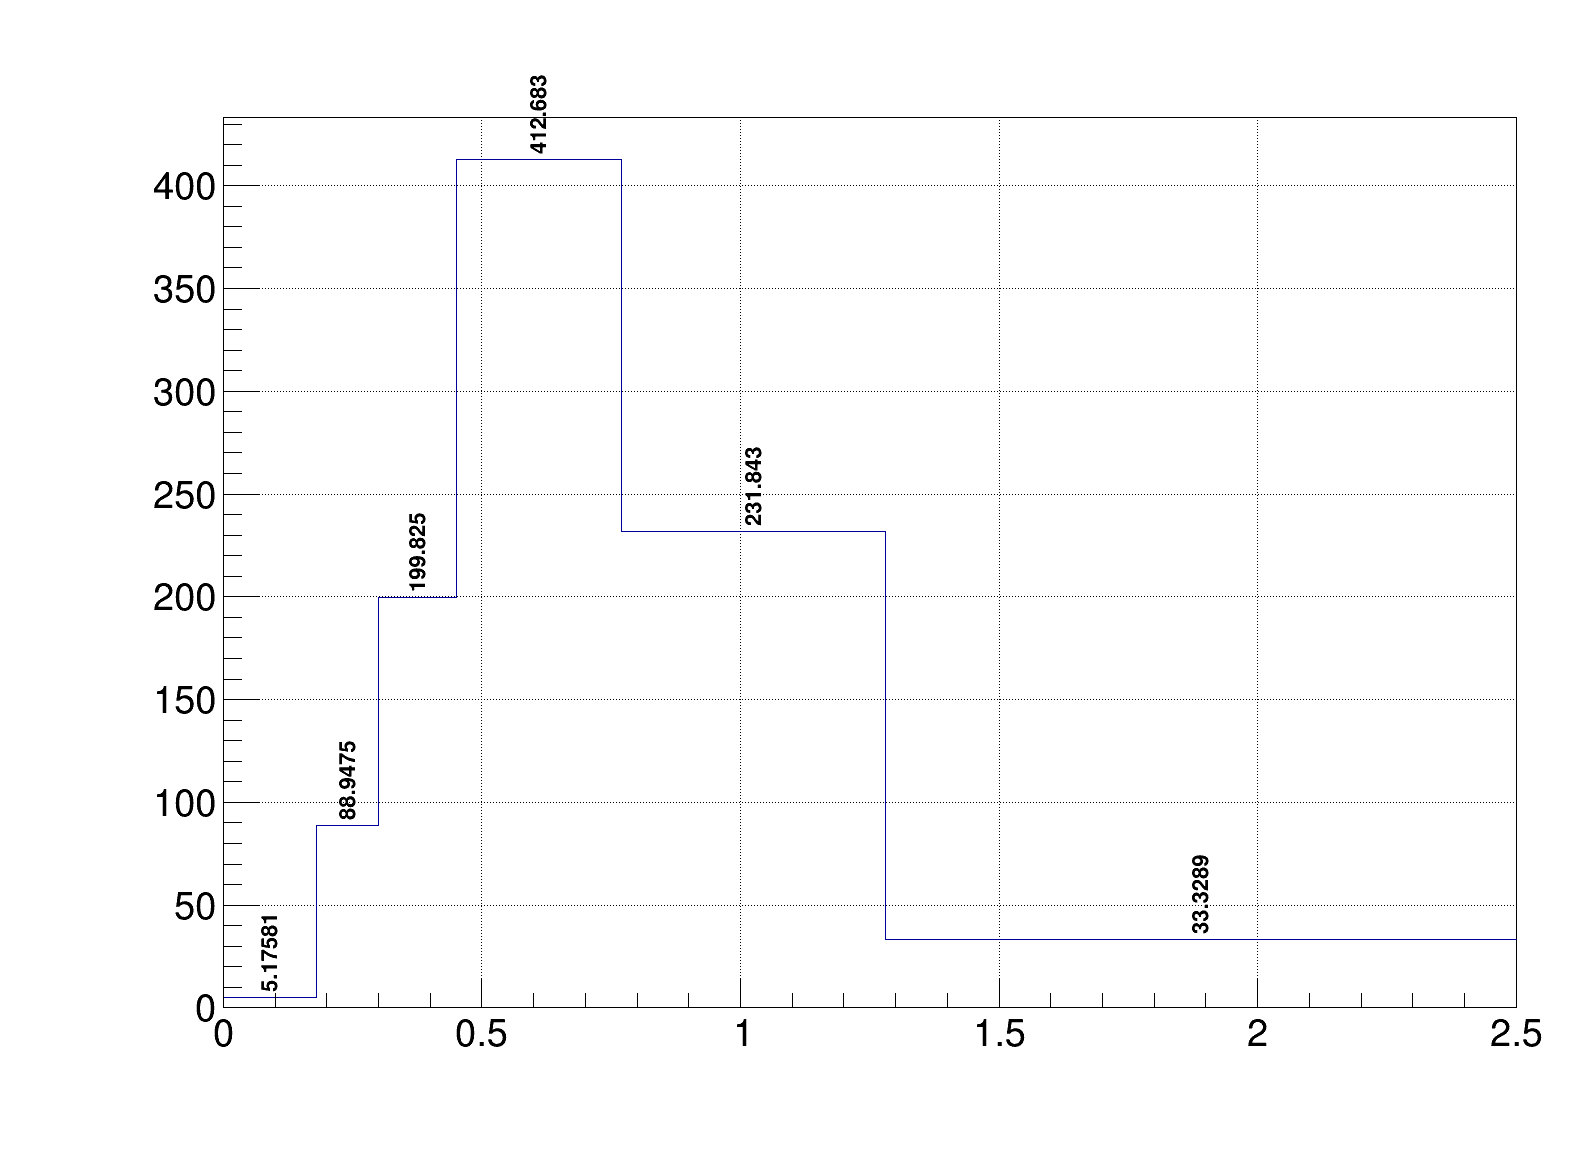

In [22]:
h_test.Draw('hist text')
c1.Draw()

In [23]:
f = ROOT.TF1("my_distribution", my_distribution, 0, 2.5, binnum)
f.SetParameters(np.zeros((binnum)))
f.SetParLimits(0,0, 1000);
result = h_test.Fit(f)

print f.GetParameters()[0]

3.22519788654e-10
 FCN=0.274963 FROM MIGRAD    STATUS=CONVERGED     254 CALLS         255 TOTAL
                     EDM=3.99229e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.22520e-10   8.40564e-03   3.19477e-06** at limit **
   2  p1           5.47004e-03   1.38024e-03   6.71954e-07  -2.16990e-02
   3  p2           6.60401e-03   1.13045e-03   5.08055e-07  -3.32810e-01
   4  p3           8.38043e-03   6.86696e-04   3.09455e-07   6.81958e-01
   5  p4           5.42023e-03   6.67393e-04   2.74368e-07   1.27706e+00
   6  p5           9.35493e-04   1.06572e-03   4.84264e-07   3.57786e-01


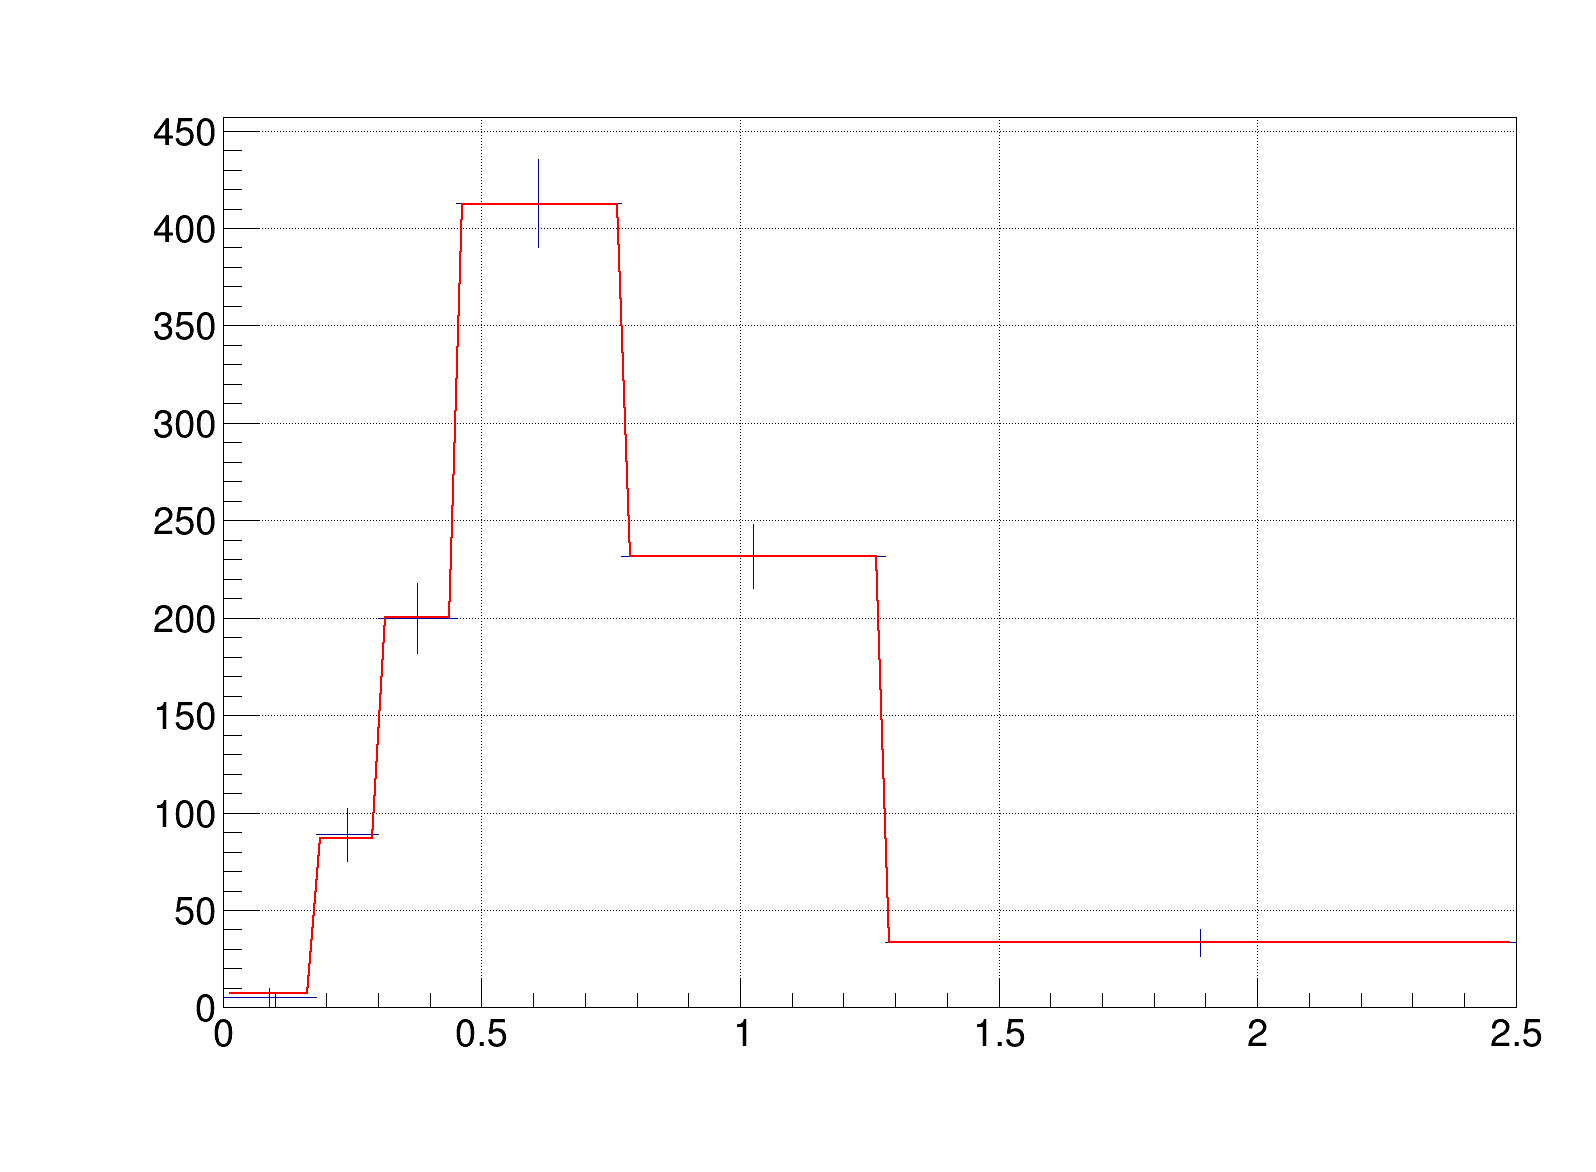

In [24]:
h_test.Draw()
f.Draw('same')
c1.Draw()

In [25]:
h_true = ROOT.TH1F('h_true','h_true',binnum,array('f',mom_bins))
globale.overlay_out.Draw('TrackMomMCS_mom>>h_true',weight_name+'*('+cut+')')

166128L

1939.45232725 3.22519788654e-10 4198.64306641
15601.9966974 0.00547004477046 24289.0742188
27581.5286179 0.00660401191469 39305.578125
52744.8252182 0.00838043468871 63503.9296875
45990.1004753 0.00542023189715 47967.4453125
14610.4964113 0.000935492728536 14390.359375


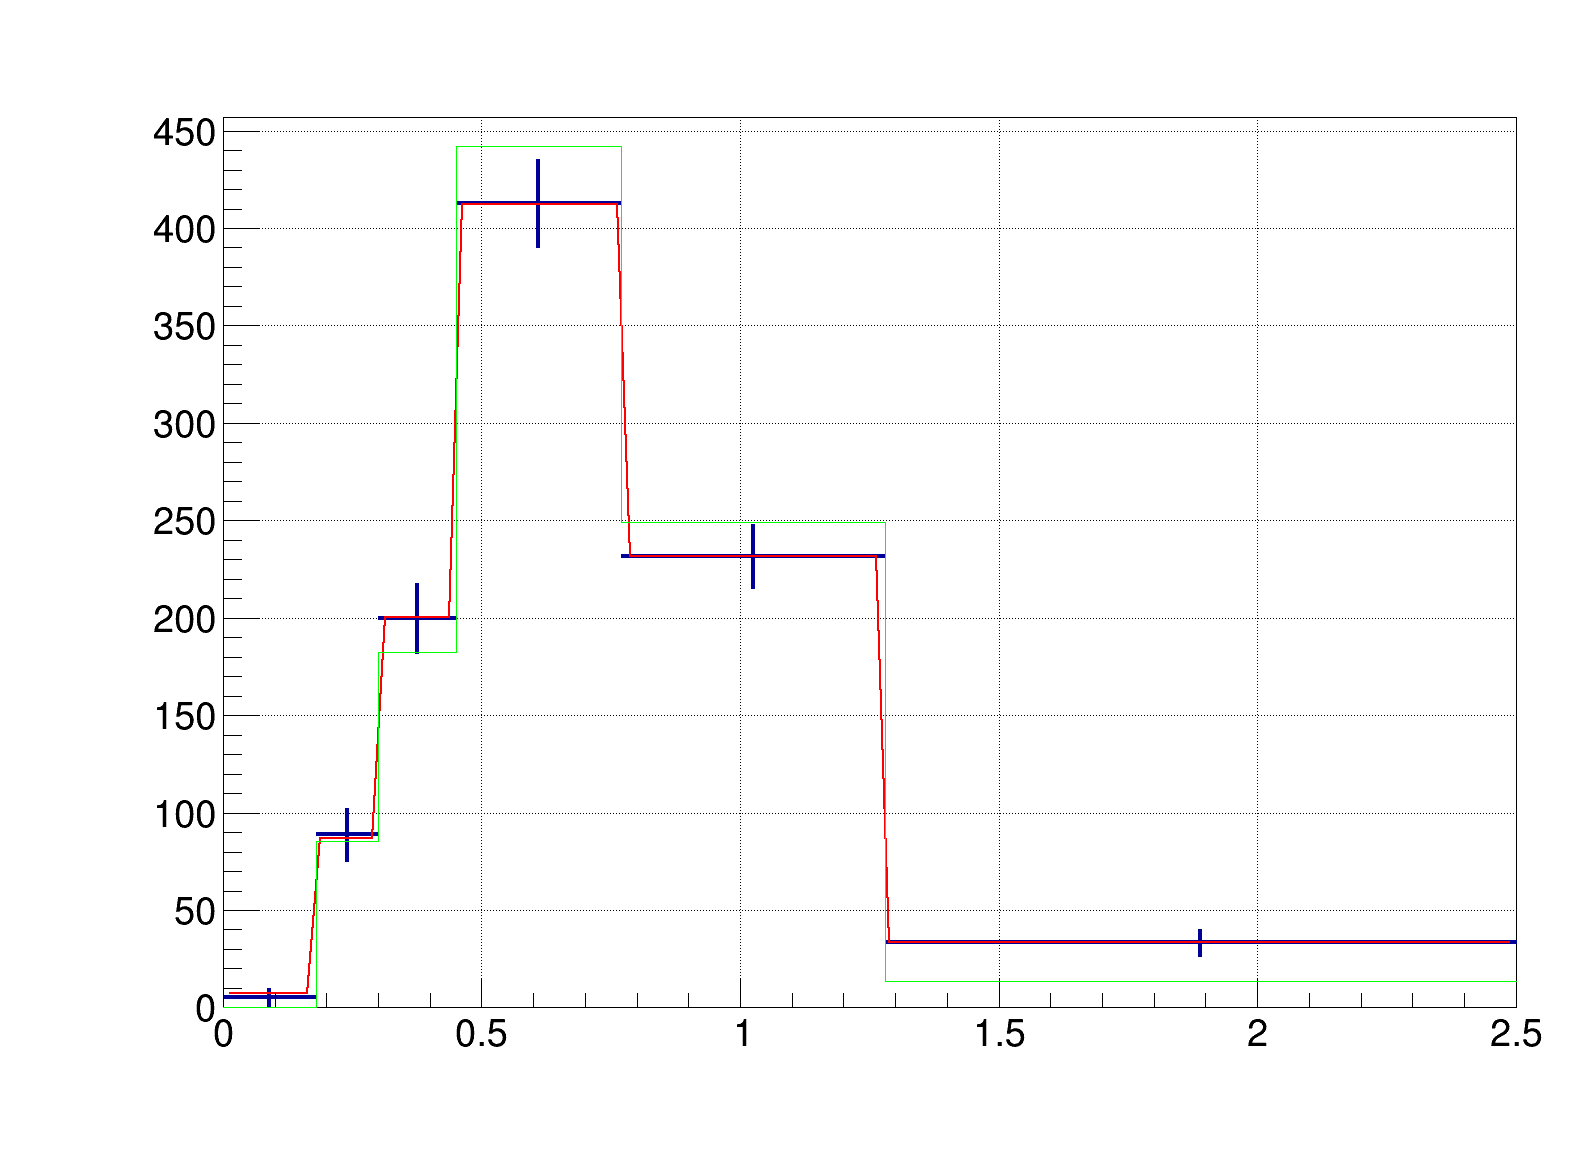

In [26]:
h_true_fit = ROOT.TH1F('h_true_fit','h_true_fit',binnum,array('f',mom_bins))
h_true_fit.SetLineColor(ROOT.kGreen)
for i in range(binnum):
    #print i,  h_temp[i].GetSumOfWeights(),  h_temp[i].Integral(0,binnum+1)
    #h_tmp = h_temp[i].Clone()
    #h_tmp.Scale(f.GetParameters()[i])
    #h_true_fit.Add(h_tmp)
    
    
    
    num_true = h_temp[i].GetSumOfWeights() #Integral(0,binnum)
    fit_scale = f.GetParameters()[i]
    print num_true, fit_scale, h_true.GetBinContent(i+1)
    h_true_fit.SetBinContent(i+1,num_true*fit_scale)
h_test.SetLineWidth(4)
h_test.Draw('')
h_true_fit.Draw('same')
c1.Draw()

In [27]:
a = [1,2,3]
b = [10,20,30]
print np.dot(a,b)

140


In [28]:
# Nselected and N generated
title = 'MCS momentum efficiency'
weight_name = 'EventWeight*TunedCentralValue_Genie'
nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,binnum,array('f',mom_bins))
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,binnum,array('f',mom_bins))
globale.overlay_out.Draw('MCle_Energy>>h_init_eff_energy',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('MCle_Energy>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')

#h_init_eff_energy.Write("h_eff_true_energy_z")
#h_init_eff_energy_1.Write("h_eff_true_energy_n")

251443L

In [29]:
h_eff_true = h_init_eff_energy.Clone()
h_eff_true.Divide(h_init_eff_energy_1)

True

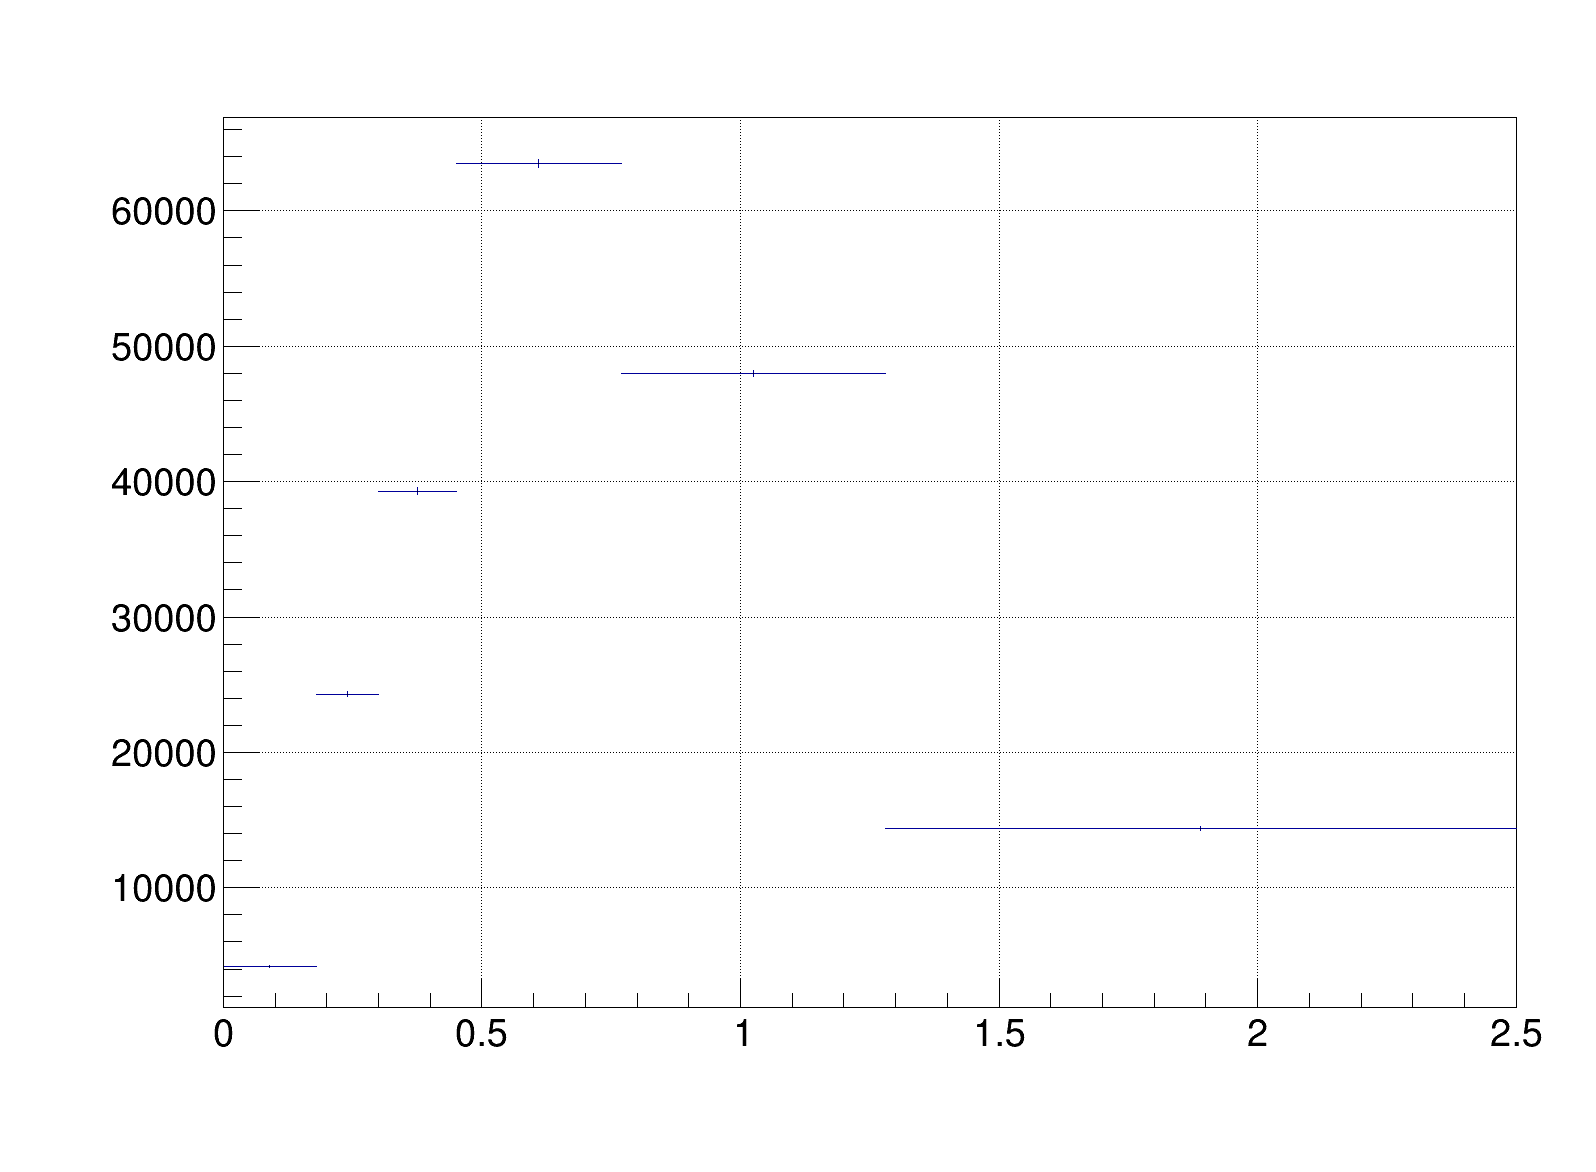

In [30]:
h_true.Draw()
c1.Draw()

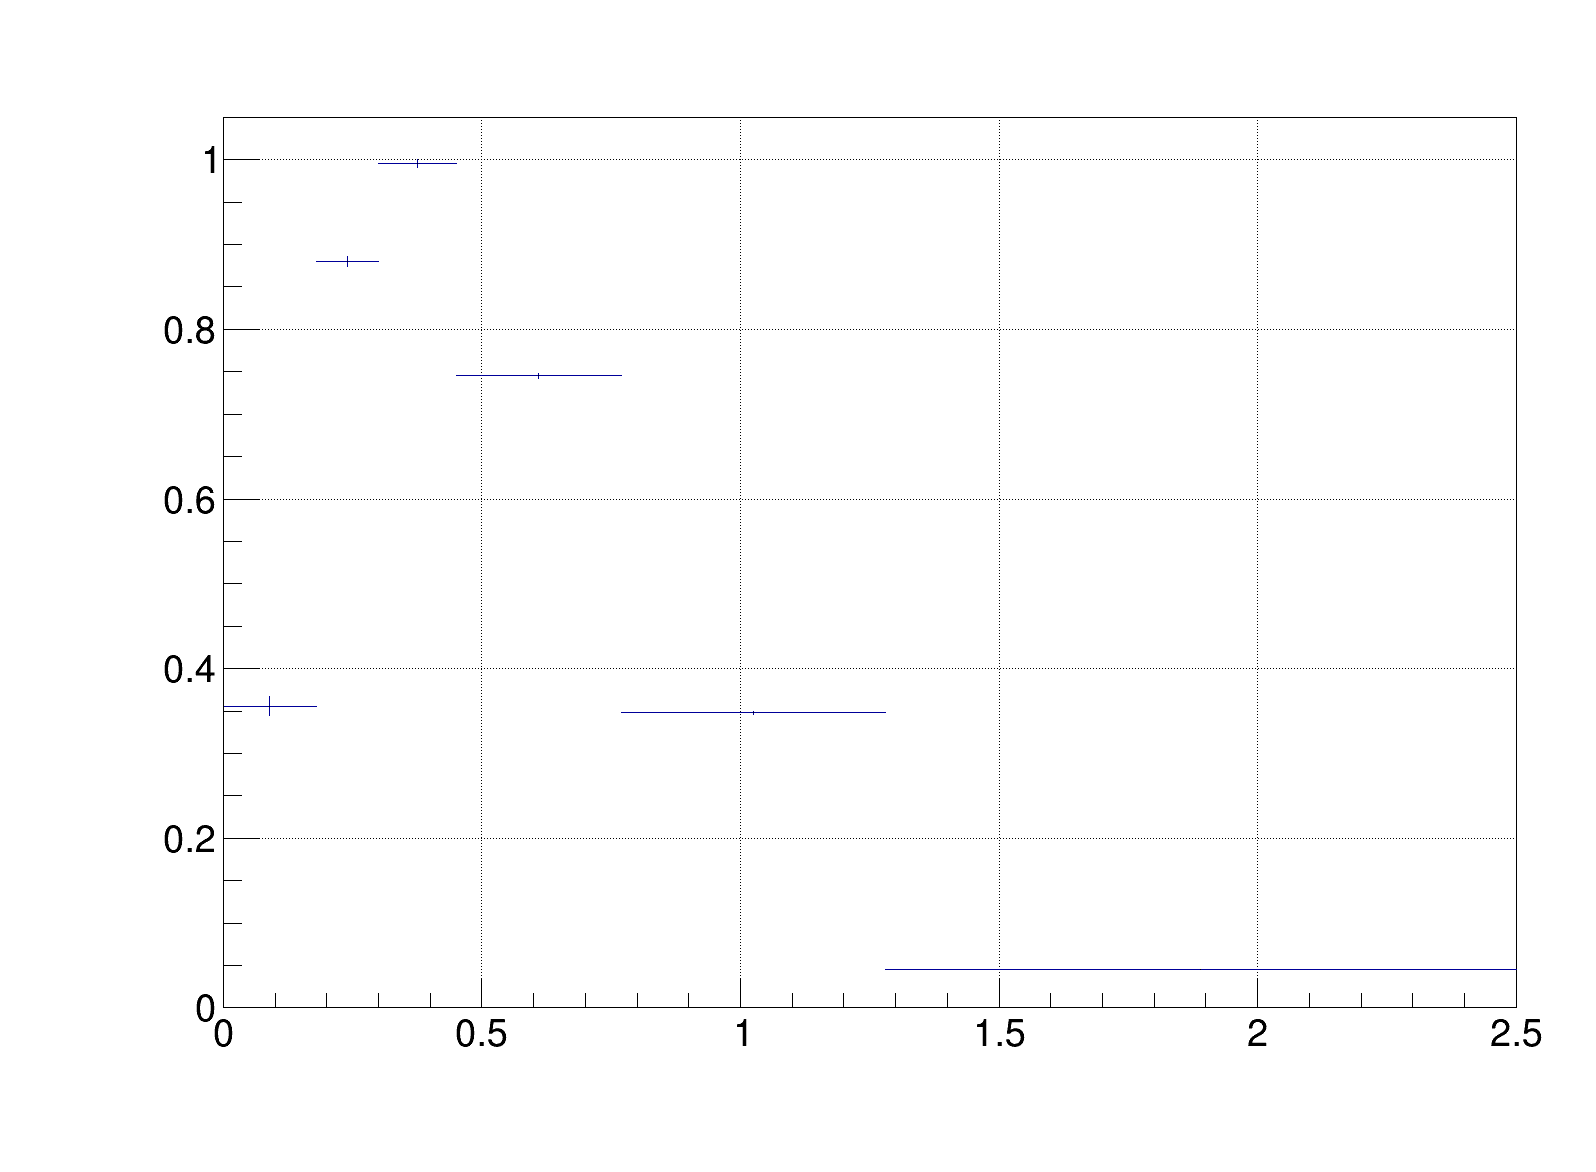

In [31]:
h_true_t = h_init_eff_energy_1.Clone()
h_true_t.Scale(scale[overlay])
h_true_t.Scale(1.0/(N_tot*beam_flux*1e-38))
#h_true_t.Divide(h_eff_true)
for i in range(1,binnum+1):
    h_true_t.SetBinContent(i,h_true_t.GetBinContent(i)/h_true_t.GetBinWidth(i))
    h_true_t.SetBinError(i,h_true_t.GetBinError(i)/h_true_t.GetBinWidth(i))
h_true_t.Draw()
c1.Draw()

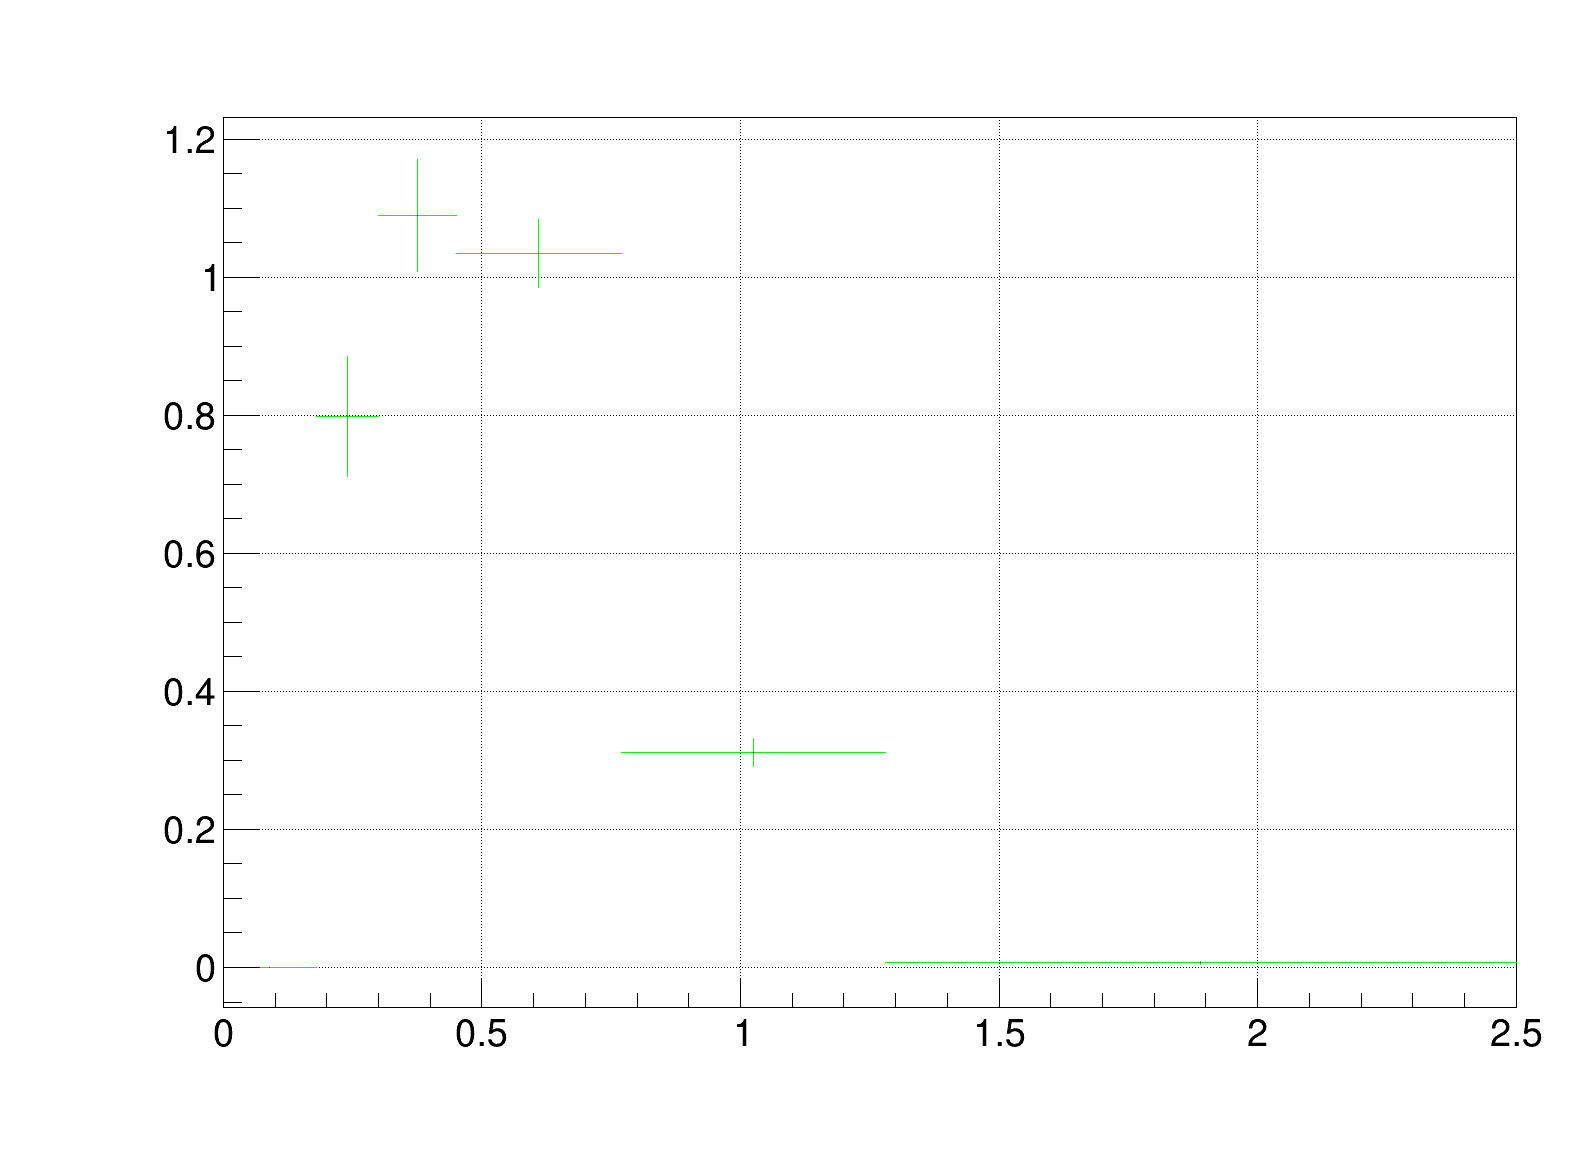

In [32]:
h_true_fit_t = h_true_fit.Clone()
h_true_fit_t.Scale(1.0/(N_tot*beam_flux*1e-38))
h_true_fit_t.Divide(h_eff_true)
for i in range(1,binnum+1):
    h_true_fit_t.SetBinContent(i,h_true_fit_t.GetBinContent(i)/h_true_fit_t.GetBinWidth(i))
    h_true_fit_t.SetBinError(i,h_true_fit_t.GetBinError(i)/h_true_fit_t.GetBinWidth(i))

h_true_fit_t.Draw()
c1.Draw()

467

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit/png/h_xsec_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit/root/h_xsec_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit/pdf/h_xsec_corr.pdf has been created


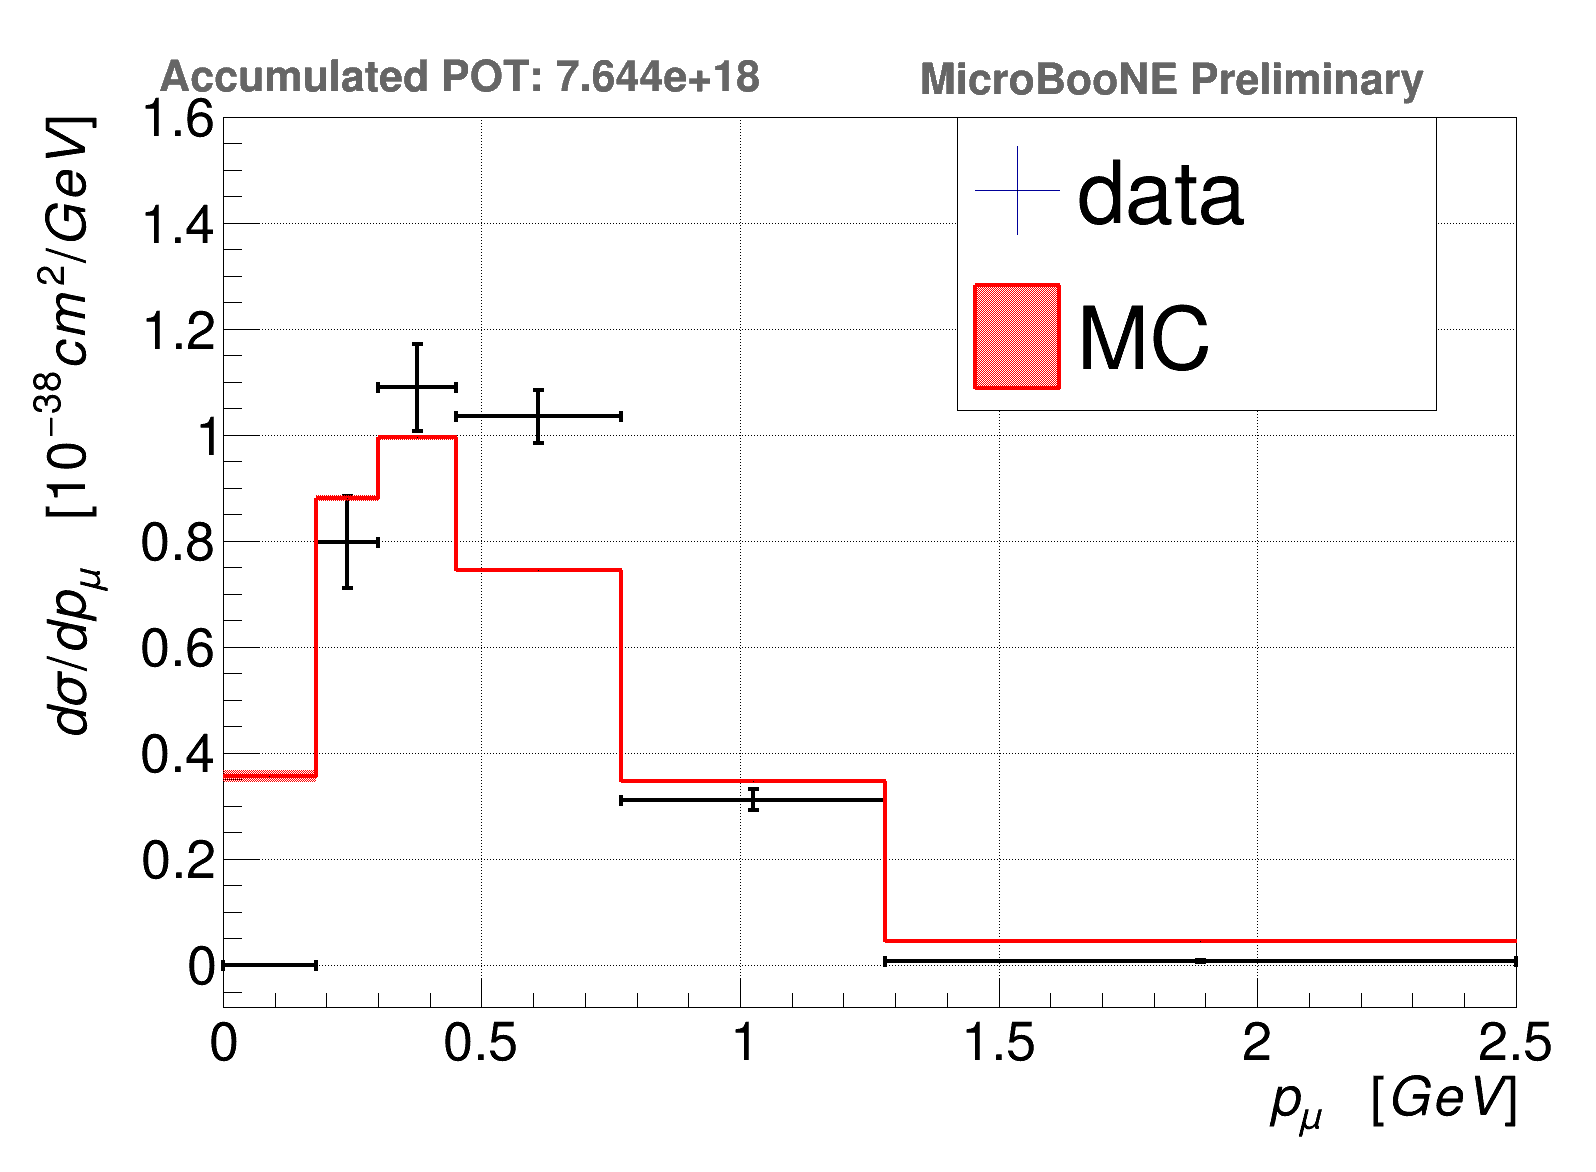

In [33]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_true_t,'MC',"f");
h_true_fit_t.SetYTitle("d\sigma / dp_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_true_fit_t.SetXTitle("p_{\mu} \t [GeV]")
h_true_fit_t.SetLineWidth(3)
h_true_fit_t.SetMaximum(1.6)

h_true_fit_t.GetYaxis().SetTitleSize(0.05)
h_true_fit_t.GetYaxis().SetTitleOffset(0.0)
h_true_fit_t.GetYaxis().SetLabelSize(0.05)
h_true_fit_t.GetXaxis().SetTitleSize(0.05)
h_true_fit_t.GetXaxis().SetLabelSize(0.05)
h_true_fit_t.GetXaxis().SetTitleOffset(1)
h_true_fit_t.SetLineColor(ROOT.kBlack)
h_true_fit_t.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_true_fit_t.Draw('E1')
h_true_t.SetLineColor(2)
h_true_t.SetFillColor(0)
h_true_t.SetLineWidth(4)
#h_true_t.Draw('hist same')
h_true_t.DrawCopy('Hist same')
h_true_t.SetFillColor(2)
h_true_t.SetFillStyle(3001)
h_true_t.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr.pdf")

h_true_fit_t.Write("h_xsec_data")
h_true_t.Write("h_xsec_MC")


In [34]:
# close the root file with all the histos
RootFile.Close()